In [1]:
import gurobipy as gb
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json
import random

plt.rcParams['font.size']=12
plt.rcParams['font.family']='serif'
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False  
plt.rcParams['axes.spines.bottom'] = True     
plt.rcParams["axes.grid"] = True
plt.rcParams['grid.linestyle'] = '-.' 
plt.rcParams['grid.linewidth'] = 0.4


In [2]:
with open('Data/ALL_scenarios.json') as f:
    all_scenarios = json.load(f)

all_scenarios.keys()

OMEGA = 250 # number of scenarios to sample
PI = 1 / OMEGA # probability of each sampled scenario - assumed to be equal

S = len(all_scenarios.keys()) - 1 # number of total scenarios
T = 24 # number of hours

WIND_CAPACITY = 200 #MWh

random.seed(123)

# Sample scenarios without replacement
in_sample_scenarios = random.sample(range(S), OMEGA)

print(in_sample_scenarios)

scenarios = {}

# Extract sampled scenarios from dictionary containing all scenarios
for i in range(len(in_sample_scenarios)):
    scenarios[str(i)] = all_scenarios[str(in_sample_scenarios[i])]
    scenarios[str(i)]['Original Index'] = in_sample_scenarios[i]
    
print('Number of extracted scenarios:', len(scenarios))


[107, 548, 178, 1574, 834, 545, 220, 1717, 1845, 1791, 78, 776, 1098, 1151, 680, 697, 1745, 106, 326, 276, 690, 1148, 683, 1437, 502, 335, 3, 1855, 893, 1584, 179, 1799, 1223, 773, 143, 13, 646, 1499, 918, 208, 1854, 89, 189, 1366, 291, 258, 1618, 1856, 43, 597, 1866, 881, 1174, 976, 543, 961, 1715, 75, 624, 703, 1068, 1641, 989, 423, 1681, 1247, 1308, 1079, 1156, 1657, 1967, 645, 25, 815, 1828, 1575, 1323, 1050, 889, 1402, 1102, 1307, 1631, 1365, 1221, 1822, 1707, 995, 1066, 1369, 859, 767, 1044, 65, 1735, 1544, 1321, 371, 1486, 1679, 169, 1871, 997, 1347, 536, 348, 685, 1135, 801, 1810, 150, 1480, 935, 793, 1173, 1594, 688, 33, 387, 1200, 180, 1703, 1286, 744, 26, 1835, 720, 469, 830, 1089, 1026, 1482, 1687, 1861, 122, 589, 1013, 1974, 1565, 1290, 1475, 477, 1114, 990, 363, 314, 910, 775, 1539, 944, 90, 20, 275, 934, 395, 525, 1636, 556, 1955, 1298, 860, 0, 222, 1264, 128, 1045, 727, 1448, 181, 887, 1838, 17, 1629, 1097, 1119, 1421, 1300, 827, 59, 660, 537, 1957, 967, 67, 1537, 1150,

In [3]:
alpha = 0.9
beta_values = np.arange(0,1 + 0.1, 0.1) #np.linspace(0, 1, 10) 

# One-price Scheme

In [11]:
def cvr_op_scheme(scenarios, WIND_CAPACITY, T, OMEGA, alpha, beta_values, minimize_printouts=False, mip_gap = 1e-4):
    results_per_beta = {}
    p_DA_values_per_beta = {}
    
    for beta in beta_values:

        print('===============================================')
        print('Solving for beta = %.2f...' % beta)

        direction = gb.GRB.MAXIMIZE #Min / Max

        m = gb.Model() # Create a Gurobi model  

        m.setParam('OutputFlag', 0)
        
        if not mip_gap == 1e-4: m.setParam('MIPGap', mip_gap) #gurobi default is 1e-4

        #============= Variables =============
        p_DA = m.addVars(T, lb=0, ub=gb.GRB.INFINITY, name="p_DA")  # day-ahead power bid
        delta = m.addVars(T, OMEGA, lb=-gb.GRB.INFINITY, ub=gb.GRB.INFINITY, name="delta")  # power imbalance
        price_coeff = m.addVars(T, OMEGA, lb=0, ub=gb.GRB.INFINITY, name="K") # price coefficient for the imbalance price wrt. the day-ahead price
        eta = m.addVars(OMEGA, lb=0, ub=gb.GRB.INFINITY, name="n")  # auxiliary variable for risk-averse term
        zeta = m.addVar(lb=-gb.GRB.INFINITY, ub=gb.GRB.INFINITY, name="zeta")  # VaR variable for risk-averse term

        #============= Objective function =============
        # Define objective function
        expected_value = gb.quicksum(PI * scenarios[str(w)]['Spot Price [EUR/MWh]'][t] * (p_DA[t] + price_coeff[t,w] * delta[t,w])
                                    for t in range(T) for w in range(OMEGA))
        
        cvar = zeta - (1 / (1 - alpha)) * gb.quicksum(PI * eta[w] for w in range(OMEGA))

        obj = (1 - beta) * expected_value + beta * cvar

        m.setObjective(obj, direction)

        #============= Constraints =============
        # Day-ahead power bid limits
        #Upper limit is the nominal wind power
        m.addConstrs(p_DA[t] <= WIND_CAPACITY for t in range(T))

        #============= Power imbalance definition (realized - bid) ===============
        m.addConstrs(delta[t,w] == scenarios[str(w)]['Wind Power [MW]'][t] - p_DA[t] for t in range(T) for w in range(OMEGA))

        #============= Price coefficient definition ===============
        # the system balance parameter is 0 if the system has a surplus and 1 if it has a deficit
        m.addConstrs(price_coeff[t,w] == 1.2 * scenarios[str(w)]['System Balance State'][t] + 0.9 * (1 - scenarios[str(w)]['System Balance State'][t]) for t in range(T) for w in range(OMEGA))

        #============= Conditional value at risk (CVaR) constraints ===============
        m.addConstrs(-gb.quicksum(
            scenarios[str(w)]['Spot Price [EUR/MWh]'][t] * (p_DA[t] + price_coeff[t,w] * delta[t,w])
            for t in range(T)) + zeta - eta[w] <= 0 for w in range(OMEGA))
        
        m.addConstrs(eta[w] >= 0 for w in range(OMEGA))

        #============= Display and run model =============
        m.update()
        m.optimize()

        #============= Results =============
        results = {}
        if m.status == gb.GRB.OPTIMAL:
            # Initialization
            for scenario in range(OMEGA):
                df = pd.DataFrame(columns=['Hour', 'DA Price [EUR/MWh]', 'Wind Power [MW]', 'DA Bid [MW]',
                                        'Imbalance [MW]', 'DA Profit [EUR]', 'Balancing Profit [EUR]',
                                        'System State', 'Balancing Price Coefficient'])
                for t in range(T):
                    df.loc[t] = [t,
                                scenarios[str(scenario)]['Spot Price [EUR/MWh]'][t],
                                scenarios[str(scenario)]['Wind Power [MW]'][t],
                                p_DA[t].x,
                                delta[t, scenario].x,
                                scenarios[str(scenario)]['Spot Price [EUR/MWh]'][t] * p_DA[t].x,
                                (scenarios[str(scenario)]['Spot Price [EUR/MWh]'][t] *
                                price_coeff[t, scenario].x *
                                delta[t, scenario].x),
                                scenarios[str(scenario)]['System Balance State'][t],
                                price_coeff[t, scenario].x]
                df['Total Profit [EUR]'] = df['DA Profit [EUR]'] + df['Balancing Profit [EUR]']

                df['Hour'] = df['Hour'].astype(int)
                df['System State'] = df['System State'].astype(int)
                df['System State'] = df['System State'].apply(lambda x: 'Deficit' if x == 1 else 'Surplus')
                df.set_index('Hour', inplace=True)
                results[scenario] = df.copy(deep=True)

                eta_values = [eta[w].x for w in range(OMEGA)]
                delta_values = [delta[t, w].x for t in range(T) for w in range(OMEGA)]
                price_coeff_values = [price_coeff[t, w].x for t in range(T) for w in range(OMEGA)]

                #Get CVaR, VaR, and expected profit  
                cvar_value = cvar.getValue()
                results['Expected Profit'] = expected_value.getValue()
                results['CVaR'] = cvar_value
                results['VaR'] = zeta.x
                p_DA_values = [p_DA[t].x for t in range(T)]

            print('-----------------------------------------------')
            print('Objective value: %.2f EUR' % m.objVal)
            print('Expected Profit: %.2f EUR' % results['Expected Profit'])
            print('CVaR: %.10f EUR' % results['CVaR'])
            print('VaR: %.2f EUR' % results['VaR'])
            print('Eta values:', eta_values)
            #print('Delta values:', delta_values)
            #print('Price coefficient values:', price_coeff_values)
            
            if not minimize_printouts:
                print('-----------------------------------------------')
                print('Day-ahead bids:')

            average_hourly_profit = np.mean([results[w]['Total Profit [EUR]'] for w in range(OMEGA)], axis=0)

            summary = pd.DataFrame(columns=['Hour', 'DA Bid [MW]', 'Average Profit [EUR]', 'Average Wind [MW]',
                                            'Median Wind [MW]', 'Average System State', 'Average Price Coefficient'])
            for t in range(T):
                summary.loc[t] = [t, p_DA[t].x, np.mean(average_hourly_profit[t]),
                                np.mean([results[w]['Wind Power [MW]'][t] for w in range(OMEGA)]),
                                np.median([results[w]['Wind Power [MW]'][t] for w in range(OMEGA)]),
                                np.mean([scenarios[str(w)]['System Balance State'][t] for w in range(OMEGA)]),
                                np.mean([price_coeff[t, w].x for w in range(OMEGA)])]

            summary['Hour'] = summary['Hour'].astype(int)
            summary.set_index('Hour', inplace=True)

            results['Summary'] = summary.copy(deep=True)

            if not minimize_printouts:
                for t in range(T):
                    print('Hour %d | Bid: %.2f MW | Average Profit: %.2f EUR' % (t, p_DA[t].x, average_hourly_profit[t]))

                print('Sum of average profits: %.2f EUR' % np.sum(average_hourly_profit))
                print('-----------------------------------------------')
                print('Runtime: %f ms' % (m.Runtime * 1e3))

            # Save results for this beta
            p_DA_values_per_beta[beta] = p_DA_values
            results_per_beta[beta] = results

        else:
            print("Optimization was not successful.")
    return results_per_beta,p_DA_values_per_beta

results_per_beta_op, p_DA_values_per_beta_op = cvr_op_scheme(scenarios, WIND_CAPACITY, T, OMEGA, alpha, beta_values, minimize_printouts=True)

Solving for beta = 0.00...
-----------------------------------------------
Objective value: 169945.65 EUR
Expected Profit: 169945.65 EUR
CVaR: -121956985.8631214947 EUR
VaR: -29874.43 EUR
Eta values: [17796134.713471413, 8972231.160447624, 8903147.05558585, 8787400.839964995, 17821292.947641138, 8862751.265344543, 17976002.205706198, 17649587.41136125, 8853973.357651697, 8912655.483636321, 8887897.47278729, 8951606.388271816, 8925320.608514369, 8893388.717104515, 8921369.962191997, 8938055.763711125, 8800789.21530935, 17813703.00827363, 17760147.71211562, 8967470.509107605, 8952962.104883729, 8974967.335820766, 8945144.740902346, 8881082.646633796, 17610805.156538855, 8953129.128271857, 17697074.85974125, 8847620.98947581, 8904160.672218245, 8824552.100526761, 8963158.497123022, 8814548.31995717, 17630937.30555227, 8829367.749561785, 8869099.625935623, 17714411.092106387, 8911823.21844919, 8883961.07848581, 17631482.00724059, 17730505.906813025, 8861156.111215329, 8915908.3588649, 8950

In [250]:
results_per_beta_op[0.5]['Summary'].round(2)

,DA Bid [MW],Average Profit [EUR],Average Wind [MW],Median Wind [MW],Average System State,Average Price Coefficient
Hour,,,,,,
0,0.0,6088.45,75.97,58.19,0.62,1.09
1,0.0,6201.17,75.42,58.49,0.82,1.14
2,0.0,5634.33,74.73,56.26,0.61,1.08
3,0.0,5337.31,74.22,60.80,0.62,1.09
4,0.0,4900.24,73.43,59.65,0.38,1.01
5,0.0,5310.14,72.98,64.69,0.44,1.03
6,200.0,6318.35,72.05,73.15,0.18,0.96
7,0.0,6812.61,71.76,73.44,0.43,1.03
8,200.0,7829.89,72.01,79.26,0.24,0.97


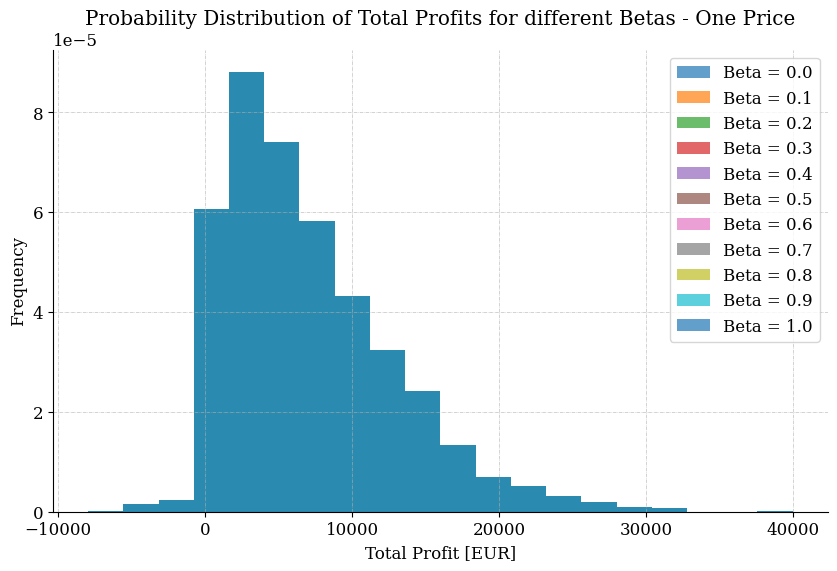

In [32]:
# Collect total profits for all scenarios for each beta
all_scenario_profits_per_beta = {beta: [] for beta in beta_values}
for beta, result in results_per_beta_op.items():
    for w in range(OMEGA):
        all_scenario_profits_per_beta[beta].extend(result[w]['Total Profit [EUR]'])

# Plot the probability distribution of profits for all scenarios for each beta
plt.figure(figsize=(10, 6))
for beta, profits in all_scenario_profits_per_beta.items():
    plt.hist(profits, bins=20, density=True, alpha=0.7, label=f'Beta = {beta.round(1)}')
plt.title('Probability Distribution of Total Profits for different Betas - One Price')
plt.xlabel('Total Profit [EUR]')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True)
plt.show()



# Two-price Scheme

In [4]:
def cvr_tp_scheme(scenarios, WIND_CAPACITY, T, OMEGA, alpha, beta_values, minimize_printouts=False, mip_gap = 1e-4):

    results_per_beta = {}
    p_DA_values_per_beta = {}
    
    for beta in beta_values: 

        print('===============================================')
        print('Solving for beta = %.2f...' % beta)

        direction = gb.GRB.MAXIMIZE #Min / Max

        m = gb.Model() # Create a Gurobi model  

        m.setParam('OutputFlag', 0)
        
        if not mip_gap == 1e-4: m.setParam('MIPGap', mip_gap) #gurobi default is 1e-4

        #============= Variables =============
        p_DA = m.addVars(T, lb=0, ub=gb.GRB.INFINITY, name="p_DA") # day-ahead power bid
        delta = m.addVars(T, OMEGA, lb=-gb.GRB.INFINITY, ub=gb.GRB.INFINITY, name="delta") # decision variable for the power imbalance - can be negative
        delta_up = m.addVars(T, OMEGA, lb=0, ub=gb.GRB.INFINITY, name="delta_up") # surplus
        delta_down = m.addVars(T, OMEGA, lb=0, ub=gb.GRB.INFINITY, name="delta_down") # deficit
        eta = m.addVars(OMEGA, lb=0, ub=gb.GRB.INFINITY, name="n")  # auxiliary variable for risk-averse term
        zeta = m.addVar(lb=-gb.GRB.INFINITY, ub=gb.GRB.INFINITY, name="zeta")  # VaR variable for risk-averse term

        imbalance_revenue = m.addVars(T, OMEGA, lb=-gb.GRB.INFINITY, ub=gb.GRB.INFINITY, name="I") # imbalance revenue - can be negative

        # binary variables used to control the two-price logic
        y = m.addVars(T, OMEGA, vtype=gb.GRB.BINARY, name="y")
        z = m.addVars(4, T, OMEGA, vtype=gb.GRB.BINARY, name="z")

        #============= Objective function =============
        # Set objective function
        expected_value = gb.quicksum(PI * (scenarios[str(w)]['Spot Price [EUR/MWh]'][t] * p_DA[t] + imbalance_revenue[t,w]) for t in range(T) for w in range(OMEGA))
        
        cvar = zeta - (1 / (1 - alpha)) * gb.quicksum(PI * eta[w] for w in range(OMEGA))
        obj = (1 - beta)*expected_value + beta*cvar

        m.setObjective(obj, direction)

        #============= Day-ahead power bid limits ============

        #Upper limit is the nominal wind power
        m.addConstrs(p_DA[t] <= WIND_CAPACITY for t in range(T))

        #============= Power imbalance definitions ===============
        m.addConstrs(delta[t,w] == scenarios[str(w)]['Wind Power [MW]'][t] - p_DA[t] for t in range(T) for w in range(OMEGA))
        m.addConstrs(delta[t,w] == delta_up[t,w] - delta_down[t,w] for t in range(T) for w in range(OMEGA))


        M = 1e6 # big-M constant
        #ensure that only one of the delta directions can be non-zero
        m.addConstrs(delta_up[t,w] <= M * (1 - y[t,w]) for t in range(T) for w in range(OMEGA))
        m.addConstrs(delta_down[t,w] <= M * y[t,w] for t in range(T) for w in range(OMEGA))

        #============= Linearized conditional statements ===============
        #Binary variable constraints
        m.addConstrs(z[0,t,w] <= y[t,w] + scenarios[str(w)]['System Balance State'][t] for t in range(T) for w in range(OMEGA))
        m.addConstrs(z[1,t,w] <= y[t,w] + (1 - scenarios[str(w)]['System Balance State'][t]) for t in range(T) for w in range(OMEGA))
        m.addConstrs(z[2,t,w] <= (1 - y[t,w]) + scenarios[str(w)]['System Balance State'][t] for t in range(T) for w in range(OMEGA))
        m.addConstrs(z[3,t,w] <= (1 - y[t,w]) + (1 - scenarios[str(w)]['System Balance State'][t]) for t in range(T) for w in range(OMEGA))

        # if system is in a surplus and the imbalance is positive (NOT helping the system)
        m.addConstrs(imbalance_revenue[t,w] <= 0.9 * scenarios[str(w)]['Spot Price [EUR/MWh]'][t] * delta_up[t,w] + M * z[0,t,w] for t in range(T) for w in range(OMEGA))

        # if system is in a deficit and the imbalance is positive (IS helping the system)
        m.addConstrs(imbalance_revenue[t,w] <= 1.0 * scenarios[str(w)]['Spot Price [EUR/MWh]'][t] * delta_up[t,w] + M * z[1,t,w] for t in range(T) for w in range(OMEGA))

        # if system is in a surplus and the imbalance is negative (IS helping the system)
        m.addConstrs(imbalance_revenue[t,w] <= -1.0 * scenarios[str(w)]['Spot Price [EUR/MWh]'][t] * delta_down[t,w] + M * z[2,t,w] for t in range(T) for w in range(OMEGA))

        # if system is in a deficit and the imbalance is negative (NOT helping the system)
        m.addConstrs(imbalance_revenue[t,w] <= -1.2 * scenarios[str(w)]['Spot Price [EUR/MWh]'][t] * delta_down[t,w] + M * z[3,t,w] for t in range(T) for w in range(OMEGA))

        #============= Conditional value at risk (CVaR) constraints ===============
        m.addConstrs(-gb.quicksum(
            scenarios[str(w)]['Spot Price [EUR/MWh]'][t] * p_DA[t] + imbalance_revenue[t,w]
            for t in range(T)) + zeta - eta[w] <= 0 for w in range(OMEGA))
        
        m.addConstrs(eta[w] >= 0 for w in range(OMEGA))

        #============= Display and run model =============
        m.update()
        #m.display()
        m.optimize()

        #============= Results =============
        results = {}
        if m.status == gb.GRB.OPTIMAL:
            #initialization
            for scenario in range(OMEGA):
                df = pd.DataFrame(columns=['Hour', 'DA Price [EUR/MWh]', 'Wind Power [MW]', 'DA Bid [MW]', 'Delta [MW]', 'Delta UP [MW]', 'Delta DOWN [MW]' ,'DA Profit [EUR]', 'Balancing Profit [EUR]', 'System State'])
                
                for t in range(T):
                    df.loc[t] = [t, 
                                scenarios[str(scenario)]['Spot Price [EUR/MWh]'][t], 
                                scenarios[str(scenario)]['Wind Power [MW]'][t], p_DA[t].x,
                                delta[t,scenario].x, 
                                delta_up[t,scenario].x, 
                                delta_down[t,scenario].x, 
                                scenarios[str(scenario)]['Spot Price [EUR/MWh]'][t] * p_DA[t].x, 
                                imbalance_revenue[t,scenario].x, 
                                scenarios[str(scenario)]['System Balance State'][t]]
                df['Total Profit [EUR]'] = df['DA Profit [EUR]'] + df['Balancing Profit [EUR]']

                df['Hour'] = df['Hour'].astype(int)
                df['System State'] = df['System State'].astype(int)
                df['System State'] = df['System State'].apply(lambda x: 'Deficit' if x == 1 else 'Surplus')
                df.set_index('Hour', inplace=True)
                results[scenario] = df.copy(deep=True)

                eta_values = [eta[w].x for w in range(OMEGA)]

            #Get CVaR, VaR, and expected profit    
            cvar_value = cvar.getValue()
            results['Expected Profit'] = expected_value.getValue()
            results['CVaR'] = cvar_value
            results['VaR'] = zeta.x
            p_DA_values = [p_DA[t].x for t in range(T)]

            print('-----------------------------------------------')
            print('Objective value: %.2f EUR' % m.objVal)
            print('Expected Profit: %.2f EUR' % results['Expected Profit'])
            print('CVaR: %.10f EUR' % results['CVaR'])
            print('VaR: %.2f EUR' % results['VaR'])
            print('Eta values:', eta_values)

            if not minimize_printouts:
                print('-----------------------------------------------')
                print('Day-ahead bids:')

            average_hourly_profit = np.mean([results[w]['Total Profit [EUR]'] for w in range(OMEGA)], axis=0)

            summary = pd.DataFrame(columns=['Hour', 'DA Bid [MW]', 'Average Profit [EUR]', 'Average Wind [MW]', 'Median Wind [MW]', 'Average System State'])
            for t in range(T):
                summary.loc[t] = [t, p_DA[t].x, np.mean(average_hourly_profit[t]), np.mean([results[w]['Wind Power [MW]'][t] for w in range(OMEGA)]), np.median([results[w]['Wind Power [MW]'][t] for w in range(OMEGA)]), np.mean([scenarios[str(w)]['System Balance State'][t] for w in range(OMEGA)])]

            summary['Hour'] = summary['Hour'].astype(int)
            summary.set_index('Hour', inplace=True)

            results['Summary'] = summary.copy(deep=True)

            if not minimize_printouts:
                for t in range(T):
                    print('Hour %d | Bid: %.2f MW | Average Profit: %.2f EUR' % (t, p_DA[t].x, average_hourly_profit[t]))

                print('Sum of average profits: %.2f EUR' % np.sum(average_hourly_profit))
                print('-----------------------------------------------')
                print('Runtime: %f ms' % (m.Runtime * 1e3))

            for scenario in range(OMEGA):
                for t in range(T):
                    if np.round(sum([z[i,t,scenario].x for i in range(4)]), 4) != 3:
                        print('WARNING: SCENARIO %d | HOUR %d | z:' % (scenario, t), z[0,t,scenario].x, z[1,t,scenario].x, z[2,t,scenario].x, z[3,t,scenario].x)
             # Save results for this beta
            p_DA_values_per_beta[beta] = p_DA_values
            results_per_beta[beta] = results

        else:
            print("Optimization was not successful.")
    return results_per_beta,p_DA_values_per_beta

results_per_beta_tp, p_DA_values_per_beta_tp = cvr_tp_scheme(scenarios, WIND_CAPACITY, T, OMEGA, alpha, beta_values, minimize_printouts=True)

Solving for beta = 0.00...
Set parameter Username
Academic license - for non-commercial use only - expires 2025-04-26
-----------------------------------------------
Objective value: 152856.03 EUR
Expected Profit: 152856.03 EUR
CVaR: 0.0000000000 EUR
VaR: 0.00 EUR
Eta values: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.

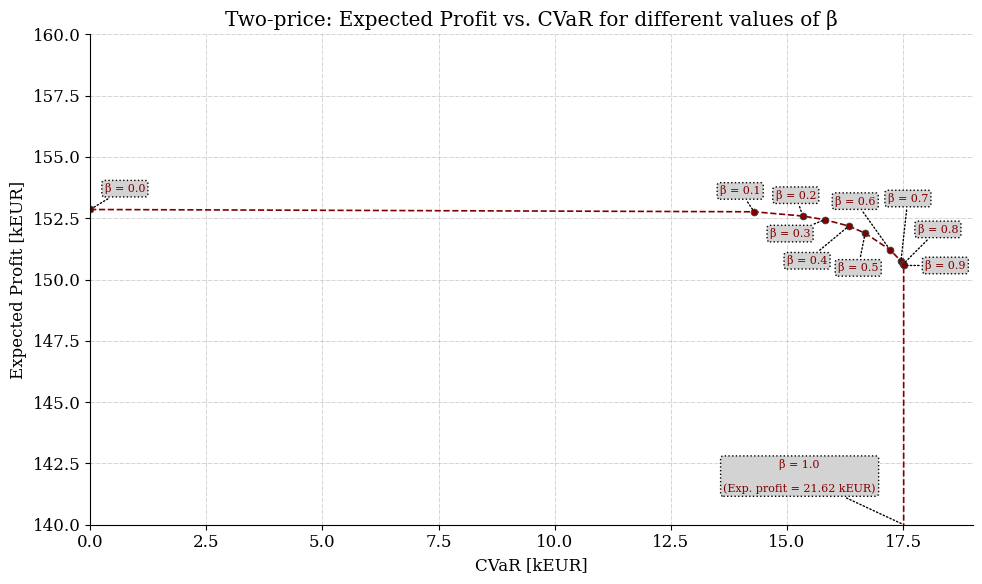

In [5]:
# Plot expected value vs. CVaR for different beta values

fig = plt.figure(figsize=(10, 6))

ax = fig.gca()
betas = list(results_per_beta_tp.keys())
expected_profit = [results_per_beta_tp[beta]['Expected Profit'] / 1e3 for beta in betas]
cvar_values = [results_per_beta_tp[beta]['CVaR'] / 1e3 for beta in betas]


# Adjust bbox and arrowprops as needed
arrowprops = dict(linestyle="dotted", arrowstyle='-', color='black', alpha=1)
bbox_props = dict(boxstyle="round,pad=0.25", fc="lightgrey", ec="black", lw=1, linestyle=':', alpha=1)

offsets = [(25,15),   # 0.0
           (-10,15),  # 0.1
           (-5,15),   # 0.2
           (-25,-10), # 0.3
           (-30,-25), # 0.4
           (-5,-25),  # 0.5
           (-25, 35), # 0.6
           (5, 45),   # 0.7
           (25,25),   # 0.8
           (30,0),    # 0.9
           (-75,35)]  # 1.0


for i in range(len(betas)):
    if i < (len(betas) - 1): 
        label = '\u03B2 = %.1f' % betas[i]
        xy = (cvar_values[i], expected_profit[i])
    else: 
        label = '\u03B2 = %.1f\n\n(Exp. profit = %.2f kEUR)' % (betas[i], expected_profit[i])
        xy = (cvar_values[i], 140)

    ax.annotate(label, 
                    xy=xy, 
                    xytext=offsets[i], 
                    xycoords='data', 
                    textcoords='offset points', 
                    arrowprops=arrowprops,
                    bbox=bbox_props,
                    fontsize=8,
                    color='maroon',
                    ha = 'center',
                    va = 'center',
                    rotation=0,
                    clip_on=False,
                    annotation_clip=False)


plt.plot(cvar_values, expected_profit, marker='o', linestyle='--', color='maroon', markersize=5, markeredgecolor='darkslategray', markeredgewidth=0.5, linewidth=1.2)
plt.xlabel('CVaR [kEUR]')
plt.ylabel('Expected Profit [kEUR]')

plt.yticks(np.arange(140, 161, 2.5))
plt.xticks(np.arange(0, 20, 2.5))

plt.xlim([0,19000 / 1e3])
ax.set_ylim([140000 / 1e3, 160000 / 1e3])

plt.title('Two-price: Expected Profit vs. CVaR for different values of \u03B2')

#plt.savefig('Figures/Two-price_Expected_Profit_vs_CVaR.png', dpi=300, bbox_inches='tight')

plt.tight_layout()
plt.show()


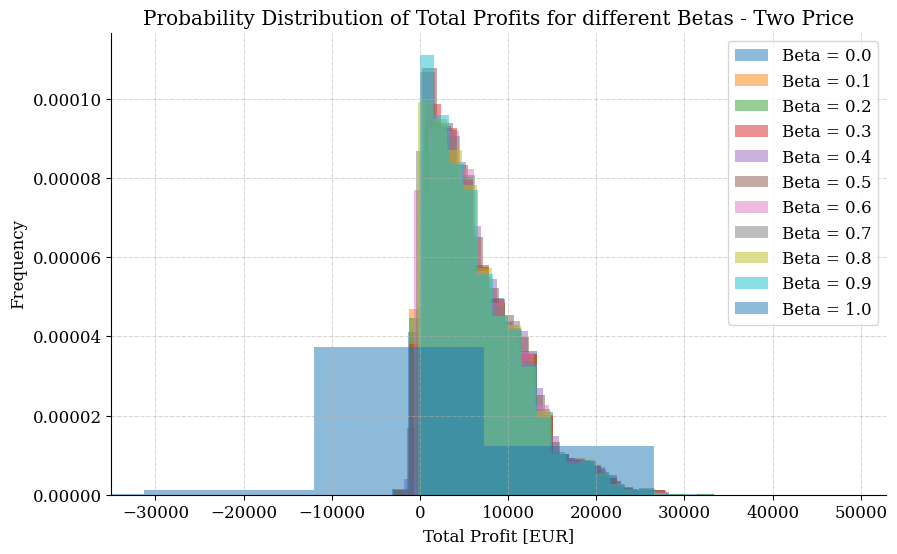

In [27]:
# Collect total profits for all scenarios for each beta
all_scenario_profits_per_beta_tp = {beta: [] for beta in beta_values}
for beta, result in results_per_beta_tp.items():
    for w in range(OMEGA):
        all_scenario_profits_per_beta_tp[beta].extend(result[w]['Total Profit [EUR]'])

# Plot the probability distribution of profits for all scenarios for each beta
plt.figure(figsize=(10, 6))
for beta, profits in all_scenario_profits_per_beta_tp.items():
    plt.hist(profits, bins=20, density=True, alpha=0.5, label=f'Beta = {beta.round(1)}')
plt.title('Probability Distribution of Total Profits for different Betas - Two Price')
plt.xlabel('Total Profit [EUR]')
plt.ylabel('Frequency')
plt.legend()
#plt.xticks(np.arange(-5000, 51, 500))  # Custom ticks for x-axis from -5000 to 50
plt.xlim(-35000, plt.xlim()[1])
plt.grid(True)
plt.show()


# Export optimal day-ahead schedule for subsequent tasks

Create dataframe with optimal day-ahead bids for each approach - we pick the values for BETA = 0.5 as a "conservative" choice

In [225]:
BETA_EXPORT = 0.5 # the beta value to export day-ahead bids for

df = pd.DataFrame(columns=['Hour', 'One-price Bids [MW]', 'Two-price Bids [MW]'])
df['Hour'] = range(T)
#df['One-price Bids [MW]'] = results_op['Summary']['DA Bid [MW]'].values
df['Two-price Bids [MW]'] = results_per_beta_tp[BETA_EXPORT]['Summary']['DA Bid [MW]'].values
df.set_index('Hour', inplace=True)

#df.to_csv('Data/Optimal_DA_bids_from_CVaR.csv')

df

,One-price Bids [MW],Two-price Bids [MW]
Hour,,
0,NaN,14.852837
1,NaN,13.035375
2,NaN,10.853112
3,NaN,9.277369
4,NaN,14.677845
5,NaN,14.346658
6,NaN,73.145411
7,NaN,5.386583
8,NaN,41.680830
